In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf 
from matplotlib import pyplot as plt
import math
import cv2

Shape of Image (200, 200, 3)
New Size of image, (1, 200, 200, 3)


(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x7f6482006f98>)

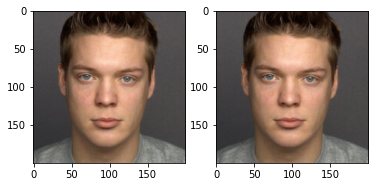

In [2]:
# Read Image 
img = cv2.imread('Images/Male_Image.jpeg')
img = img[:,:,::-1]

# Show Image 
plt.subplot(121),plt.imshow(img)
print("Shape of Image",img.shape)
img=np.expand_dims(img,0)
print("New Size of image,",img.shape)
plt.subplot(122),plt.imshow(np.squeeze(img))


In [6]:
class SpectralPooling:
    
    def __init__(self):
        self.corner_set=[(0,0)]
        pass


    def tf_fouriertransform(self,spatial_image):
        '''
        Performs Fast Fourier Transform on the input image.
        Shifts DC Component of Fourier image to the Center
        
        Inputs: 
        1) Spatial image , Real value , dimensions [channels,length,width]
        
        Outputs: 
        1) Spectral image , Complex value Array , dimensions [channels,length,width]
        '''
        
        # Convert it into Fourier Transform
        fourier_image = tf.signal.fft2d(spatial_image)

        # DC should be shifted to Center 
        fourier_image = tf.signal.fftshift(fourier_image)

        return fourier_image
    
    def tf_inversefouriertransform(self,fourier_image):
        '''
        Shifts DC Component of Fourier image to the top. 
        
        Performs InverseFast Fourier Transform on the input image.
        
        Inputs: 
        1) Spectral image , Complex value Array , dimensions [channels,length,width]
        
        Outputs: 
        1) Spatial image , Real value , dimensions [channels,length,width]
        
        '''
        # Shift DC back 
        fourier_image = tf.signal.ifftshift(fourier_image)

        # Convert it back into Spatial Image
        spatial_image = tf.signal.ifft2d(fourier_image)
        
        return spatial_image

    
    def tf_normalizeimage(self,spatial_image): 
        '''
        Normalize Image data to values between [0..255]
        
        Inputs: 
        1) Spatial image [length,width,channels]
        
        Outputs: 
        1) Normalized Spatial image [length,width,channels]
        
        '''
        channel_max = tf.reduce_max(spatial_image, axis=(1, 2))
        channel_min = tf.reduce_min(spatial_image, axis=(1, 2))
        
        normalized_spatialimage = tf.divide(spatial_image - channel_min,channel_max - channel_min)
        
        return normalized_spatialimage
    
    
    def tf_lowpassfilter(self,fourier_image,filter_shape):
        '''
        Builds Low Pass filter using Fourier_image size and pool_size for dimensionreduction
        
        Inputs: 
        
        1) Spectral image , Complex value Array , dimensions [channels,length,width]
        2) filter_shape , 2D shape 
        
        Outputs:
        
        1) Filtered image , Complex value Array , dimensions [channels,length,width]
        '''
        assert filter_shape[0] >= 3
        assert filter_shape[1] >= 3  
        filter_shape = list(filter_shape)
        fourierimage_size = fourier_image.shape
        
        if (fourierimage_size[2] + filter_shape[0]) % 2 == 1 : 
            filter_shape[0] += 1
            
        if (fourierimage_size[3] + filter_shape[1]) % 2 == 1 : 
            filter_shape[1] += 1
        
        top = int((fourierimage_size[2]-filter_shape[0])//2)
        bottom = int(top + filter_shape[0])

        left = int((fourierimage_size[3]-filter_shape[1])//2)
        right = int( left + filter_shape[1])
                
        filtered_image = fourier_image[:,:,top:bottom,left:right]
        
        return filtered_image 
    
    def tf_treatcornercases(self,filtered_fourier_image):
    
        height = filtered_fourier_image.shape[2]
        width  = filtered_fourier_image.shape[3]

        if height % 2 == 0 : 
            self.corner_set.append((int(height/2),0))
            if width % 2 == 0 : 
                self.corner_set.append((int(height/2),int(width/2)))

        if width % 2 == 0 : 
            self.corner_set.append((0,int(width/2)))
        
        
        # corner_set will have one entry if both height and width are odd , else it have more than one but max of 4 
        mask = np.ones(shape=filtered_fourier_image.shape)
        
        for coordinate in self.corner_set:
            mask[:,:,coordinate[0],coordinate[1]] = 0
            print(coordinate)
        filtered_fourier_image_real = tf.math.real(filtered_fourier_image)
        filtered_fourier_image_imag = tf.math.imag(filtered_fourier_image)
        filtered_fourier_image_imag = filtered_fourier_image_imag * mask
        
        filtered_fourier_image = tf.complex(filtered_fourier_image_real, filtered_fourier_image_imag)
        
        return filtered_fourier_image
    
    def spectral_pool(self,spatial_image,filter_shape=(5,5)): 
        assert filter_shape[0] > 0 , "Pool Size cannot be lesser than 1" # denominator can't be 0

        # Convert it into Channels First 
        spatial_imagechannelsfirst = tf.transpose(spatial_image,perm=[0,3,1,2])
        
        # Get Fourier Image 
        fourier_image = self.tf_fouriertransform(tf.cast(spatial_imagechannelsfirst, tf.complex64))
        

        # Apply low pass filter on Fourier Image 
        if filter_shape[0] > 1 : 
            filtered_fourier_image = self.tf_lowpassfilter(fourier_image,filter_shape)
        else :
            filtered_fourier_image = fourier_image

        filtered_fourier_image=self.tf_treatcornercases(filtered_fourier_image)

        # Convert it back into spatial image 
        filtered_spatial_image= self.tf_inversefouriertransform(filtered_fourier_image)
        
        filtered_spatial_image_channelslast = tf.math.real(tf.transpose(filtered_spatial_image,perm=[0,2,3,1]))
        filtered_spatial_image = self.tf_normalizeimage(filtered_spatial_image_channelslast)  
        
        filtered_fourier_image = tf.transpose(filtered_fourier_image,perm=[0,2,3,1])
        magnitude_spectrum = 2*np.log(np.abs(filtered_fourier_image) + 1e-45) 
        magnitude_spectrum = magnitude_spectrum/(tf.reduce_max(magnitude_spectrum))
        
        return magnitude_spectrum,filtered_spatial_image

In [7]:
spectral_pooling = SpectralPooling()

filtered_fourier_image,filtered_spatial_image = spectral_pooling.spectral_pool(img,filter_shape=(101,101))

# plt.imshow(np.squeeze(filtered_spatial_image))

(0, 0)
(51, 0)
(51, 51)
(0, 51)


(0, 0)
(2, 0)
(2, 2)
(0, 2)
(0, 0)
(3, 0)
(3, 3)
(0, 3)
(0, 0)
(6, 0)
(6, 6)
(0, 6)
(0, 0)
(13, 0)
(13, 13)
(0, 13)
(0, 0)
(25, 0)
(25, 25)
(0, 25)
(0, 0)
(100, 0)
(100, 100)
(0, 100)


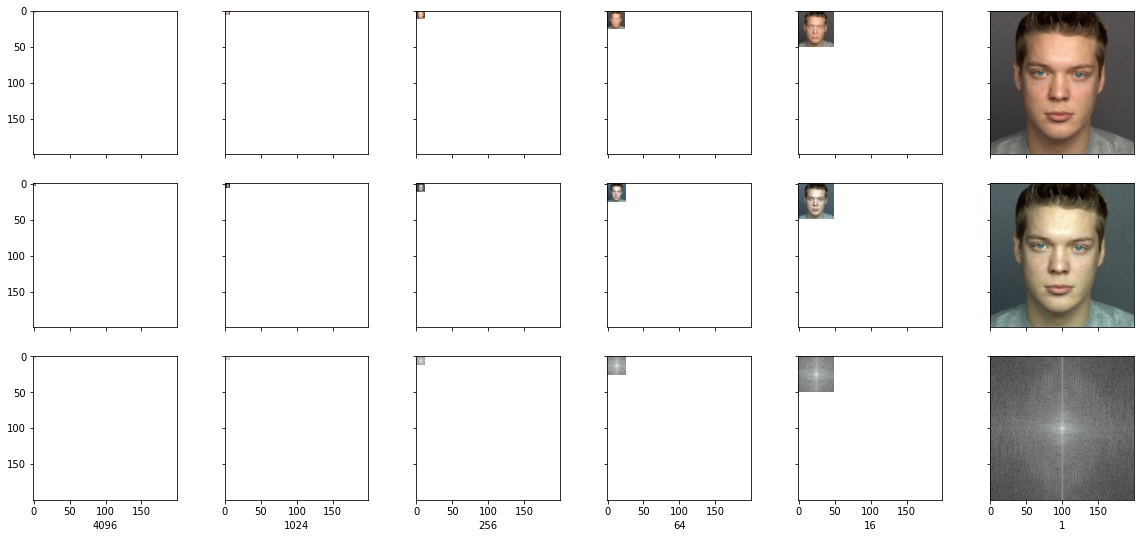

In [8]:
fig, axes = plt.subplots(3, 6, figsize=(20, 9), sharex=True, sharey=True)
pool_size = [64, 32, 16, 8, 4, 1]

for i in range(len(pool_size)):
    
    ax1 = axes[0,i]
    max_pool_2d = tf.keras.layers.MaxPooling2D(pool_size=pool_size[i])
    reduced_image = max_pool_2d(img)

    ax1.imshow(np.squeeze(reduced_image))
    
    filter_shape = (img.shape[1]//(pool_size[i]),img.shape[2]//(pool_size[i]))
    spectral_pooling = SpectralPooling()
    magnitude_spectrum,filtered_spatial_image = spectral_pooling.spectral_pool(img,filter_shape)
    ax1 = axes[1,i]
    ax1.imshow(np.squeeze(filtered_spatial_image))
    
    ax2 = axes[2,i]
    ax2.imshow(np.squeeze(magnitude_spectrum))
    ax2.set_xlabel(pool_size[i]**2)

In [9]:
def _frequency_drop_mask(fourier_image,freq_dropout_lower):
        
        fourierimage_size = fourier_image.shape
        
        lowpass = np.ones(shape=fourierimage_size, dtype=np.float32)         
        
        if (fourierimage_size[1] + freq_dropout_lower) % 2 == 1 : 
            freq_dropout_lower += 1
            
        distance_from_corner = math.floor((fourierimage_size[0] - freq_dropout_lower) / 2)
        
        lowpass[:distance_from_corner,:] = 0
        lowpass[-distance_from_corner: ,:] = 0

        distance_from_corner = math.floor((fourierimage_size[1] - freq_dropout_lower) / 2)

        lowpass[:,:distance_from_corner] = 0
        lowpass[:,-distance_from_corner:] = 0
        
        
        return lowpass 

        

def frequency_dropout(fourier_image,freq_dropout_lower):
    lowpass = _frequency_drop_mask(fourier_image,freq_dropout_lower)
    filtered_image = fourier_image*lowpass
    return filtered_image